# A simple example for machine learning with uproot / coffea

Let's try to distinguish DY from ttW with just using rather low level inputs, and then compare to a simple M(ll) based discriminator.

In [1]:
import uproot
import awkward
import numpy as np
import pandas as pd
from uproot_methods import TLorentzVectorArray

from coffea.processor import LazyDataFrame
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (typ

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

In [3]:

# Load some prepared data
sig_file = uproot.open('DY.root')
bkg_file = uproot.open('bkg.root')

bkg_tree = bkg_file['Events']
sig_tree = sig_file['Events']
bkg = LazyDataFrame(bkg_tree, flatten=True)
sig = LazyDataFrame(sig_tree, flatten=True)

print ("Have %s signal events and %s background events"%(len(sig['MET_phi']), len(bkg['MET_phi'])))


Have 63189 signal events and 392177 background events


In [4]:
## Preprocessing data. This is rather slow, so probably building a custom data frame or dictionary would make more sense
#sig_df_in = sig_tree.pandas.df(flatten=False)
#bkg_df_in = bkg_tree.pandas.df(flatten=False)


In [5]:
def convertToDF( df ):

    eventSelection = ( (df['nLepton']==2) & (df['nVetoLepton']==2) )
    #df = df[eventSelection]
    
    jets = JaggedCandidateArray.candidatesfromcounts(
        df['nJet'],
        pt=df['Jet_pt'],
        eta=df['Jet_eta'],
        phi=df['Jet_phi'],
        mass=df['Jet_mass'],
        btag=df['Jet_btagDeepB'],
    )
    
    leptons = JaggedCandidateArray.candidatesfromcounts(
        df['nLepton'],
        pt=df['Lepton_pt'],
        eta=df['Lepton_eta'],
        phi=df['Lepton_phi'],
        mass= df['Lepton_mass'],
        charge=df['Lepton_pdgId']/abs(df['Lepton_pdgId'])
    )

    leadingJet = jets[jets.pt.argmax()]
    leadingJet = leadingJet[eventSelection]
    
    leptons = leptons[eventSelection]
    
    leadingLepton = leptons[leptons.pt.argmax()]
    
    subleadingLepton = leptons[leptons.pt.argmin()] # this works because we select events with just two leptons in the end
    
    dileptons = leptons.choose(2)
    
    met = pd.DataFrame({'pt':df['MET_pt'], 'phi':df['MET_phi']}) # there should be a better way than this, but otherwise can't select events
    
    met = met[eventSelection]
    
    return pd.DataFrame({
            'leadingJet_pt':leadingJet.pt.flatten(), 
            'lep0_pt':dileptons.i0.pt.flatten(),
            'lep0_eta':dileptons.i0.eta.flatten(),
            'lep0_phi':dileptons.i0.phi.flatten(),
            'lep0_charge':dileptons.i0.charge.flatten(),
            'lep0_mass':dileptons.i0.mass.flatten(),
            'lep1_pt':dileptons.i1.pt.flatten(),
            'lep1_eta':dileptons.i1.eta.flatten(),
            'lep1_phi':dileptons.i1.phi.flatten(),
            'lep1_charge':dileptons.i1.charge.flatten(),
            'lep1_mass':dileptons.i1.mass.flatten(),
            'mll': dileptons.mass.flatten(), 
            'dilepton_pt':dileptons.pt.flatten(),
            'MET_pt':met['pt'],
    })




In [6]:
sig_df = convertToDF( sig )
bkg_df = convertToDF( bkg )

In [7]:
#sig = sig_df_in[((sig_df_in['nLepton']==2) & (sig_df_in['nVetoLepton']==2))]
#sig_df = pd.DataFrame({'MET_pt': sig['MET_pt'], 'nGoodJet': sig['nGoodJet']})

#bkg = bkg_df_in[((bkg_df_in['nLepton']==2) & (bkg_df_in['nVetoLepton']==2))]
#bkg_df = pd.DataFrame({'MET_pt': bkg['MET_pt'], 'nGoodJet': bkg['nGoodJet']})

#print (len(my_bkg_df['MET_pt']))

In [8]:
# usually we have less signal than background
nSignal = len(sig_df['MET_pt'])

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSignal )

y_sig = np.ones(len(sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

In [9]:
# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.5*y_tmp.shape[0] ), random_state=42 )

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
#variables = ['leadingJet_pt', 'leadingLepton_pt', 'subleadingLepton_pt', 'mll', 'dilepton_pt', 'MET_pt']
variables = ['lep0_pt', 'lep0_eta', 'lep0_phi', 'lep0_charge', 'lep0_mass', 'lep1_pt', 'lep1_eta', 'lep1_phi', 'lep1_charge', 'lep1_mass']
X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]
X_myTest = X_tmp_test[['mll', 'MET_pt']]

In [11]:
NHLayer = 5
units = 100
epochs = 100
batch_size = 5120
validation_split = 0.2
earlystopping = False
dropout = 0

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

# add layers. we can play a bit with the hyper parameters here
model.add( tf.keras.layers.Dense(units=units, activation='relu', input_dim=X_train.shape[1], ))
for i in range(NHLayer):
    model.add( tf.keras.layers.Dense(units= units, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [12]:
history = model.fit(X_train.values, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
model.save( 'training.h5a' )

Train on 24159 samples, validate on 6040 samples
Epoch 1/100
24159/24159 [==============================]24159/24159 [==============================] - 1s 34us/step - loss: 1.5634 - acc: 0.5095 - val_loss: 0.7830 - val_acc: 0.5144

Epoch 2/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 8us/step - loss: 0.7679 - acc: 0.5181 - val_loss: 0.6883 - val_acc: 0.4859

Epoch 3/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 9us/step - loss: 0.6723 - acc: 0.5458 - val_loss: 0.6718 - val_acc: 0.5801

Epoch 4/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 7us/step - loss: 0.6761 - acc: 0.5571 - val_loss: 0.7150 - val_acc: 0.4856

Epoch 5/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 8us/step - loss: 0.6939 - acc: 0.5384 - val_loss: 0.6689 - val_acc: 0.5942

Epoch 6/100
24159/24159 [===============

24159/24159 [==============================]24159/24159 [==============================] - 0s 9us/step - loss: 0.5911 - acc: 0.7086 - val_loss: 0.5981 - val_acc: 0.6929

Epoch 46/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 8us/step - loss: 0.6034 - acc: 0.6826 - val_loss: 0.6347 - val_acc: 0.6373

Epoch 47/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 8us/step - loss: 0.6179 - acc: 0.6616 - val_loss: 0.5807 - val_acc: 0.7205

Epoch 48/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 8us/step - loss: 0.5872 - acc: 0.6997 - val_loss: 0.5862 - val_acc: 0.7022

Epoch 49/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 8us/step - loss: 0.5830 - acc: 0.7035 - val_loss: 0.5795 - val_acc: 0.7055

Epoch 50/100
24159/24159 [==============================]24159/24159 [============================


Epoch 90/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 8us/step - loss: 0.4978 - acc: 0.7770 - val_loss: 0.5224 - val_acc: 0.7546

Epoch 91/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 8us/step - loss: 0.5195 - acc: 0.7617 - val_loss: 0.4676 - val_acc: 0.7919

Epoch 92/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 8us/step - loss: 0.4891 - acc: 0.7763 - val_loss: 0.5403 - val_acc: 0.7437

Epoch 93/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 8us/step - loss: 0.5287 - acc: 0.7564 - val_loss: 0.5342 - val_acc: 0.7493

Epoch 94/100
24159/24159 [==============================]24159/24159 [==============================] - 0s 8us/step - loss: 0.5252 - acc: 0.7622 - val_loss: 0.4724 - val_acc: 0.7919

Epoch 95/100
24159/24159 [==============================]24159/24159 [==============

In [13]:
# use the model to predict whether an event is signal or background
y_test_pred = pd.DataFrame( model.predict( X_test.values  ) , index = X_test.index)

# as a comparison, use a mll based discriminator:
y_test_pred_mll = (1-abs(X_myTest[['mll']]-91.2)/91.2).values.flatten()

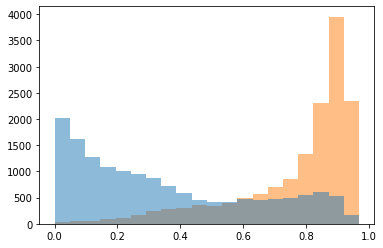

In [14]:
xbin = 20
hist, bins, ax = plt.hist( [ y_test_pred[y_test==0].values, y_test_pred[y_test==1].values ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

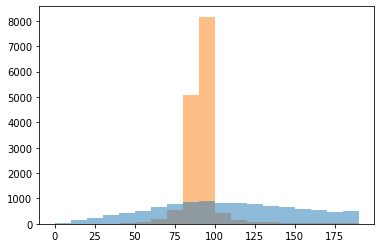

In [15]:
# just looking at M(ll)

xbin = range(0,200,10)
hist, bins, ax = plt.hist( [ X_myTest[['mll']][y_test==0].values, X_myTest[['mll']][y_test==1].values ], xbin, log=False, histtype='stepfilled', alpha=0.5) 

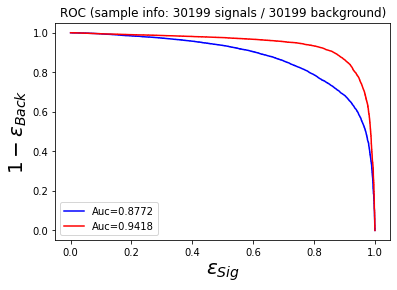

In [16]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'Auc=' + str(round(auc_val_test,4) ))

fpr_test_alt, tpr_test_alt, thresholds_test_alt = roc_curve( y_test, y_test_pred_mll )
auc_val_test_alt = auc(fpr_test_alt, tpr_test_alt)

plt.plot( tpr_test_alt, 1-fpr_test_alt, 'b', label= 'Auc=' + str(round(auc_val_test_alt,4) ), color='red')

plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')


So, our ML model doesn't learn how to compute M(ll), and even though it has more information than we use in M(ll) (**lepton charge!**), it underperforms. This could have various reasons, one being that we just use a rather small training set of 30k events, or our network is not well suited for our target.

In [17]:
from lbn import LBN, LBNLayer

In [18]:
# start a sequential model
model = tf.keras.models.Sequential()

# add the LBN layer
input_shape = (6, 4)
model.add(LBNLayer(input_shape, 10, boost_mode=LBN.PAIRS))

# add a dense layer
model.add(tf.keras.layers.Dense(1024))


AttributeError: module 'tensorflow' has no attribute 'random'